<a href="https://colab.research.google.com/github/SarahJaehnichen/MasterThesis/blob/main/00_01_MA_Prep_Demographic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Master's Thesis Analysis Part 1**

# Import Packages

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.io import savemat

# Read data

In [21]:
# ===================================================================
# Reads csv files containing experimental and participant data of AAT
# ===================================================================
df_part = pd.read_csv('participant_info.csv')
df_bo = pd.read_csv('blockOrder.csv')
df_cseq = pd.read_csv('congTrialsPS.csv', header = None)
df_iseq = pd.read_csv('incongTrialsPS.csv', header = None)
df_crt = pd.read_csv('congTrialsRT.csv', header = None)
df_irt = pd.read_csv('incongTrialsRT.csv', header = None)
df_cerrseq = pd.read_csv('congTrialsEP.csv', header = None)
df_ierrseq = pd.read_csv('incongTrialsEP.csv', header = None)

# =============================================================
# Reads .mat file containing survey rating and participant data
# =============================================================
mat = loadmat('allParticipants.mat')

# Functions

In [22]:
# Concatenates every 2nd column to the previous one
def unifyPart(df):

  # Find out number of rows. Set twice the number as the new number of rows.
  num_rows = df.shape[0]
  new_num_rows = num_rows * 2

  # Create new DataFrame with twice the number of rows and half the number of
  # columns. Add every second column below the previous one. Return changed
  # DataFrame.
  new_data = {}
  for i in range(0, df.shape[1], 2):
      col1 = df.iloc[:, i]
      col2 = df.iloc[:, i + 1]
      new_col = pd.concat([col1, col2]).reset_index(drop=True)
      new_data[f'{i//2}'] = new_col
      new_df = pd.DataFrame(new_data)
  return new_df

# Preprocessing

## AAT

Output:


*   aat_info: relevant participant information
*   aat_data: relevant experimental data from AAT

In [23]:
# ================================================================
# Create DataFrame containing all relevant participant information
# ================================================================

# DataFrame simplified by including only relevant variables
aat_info = df_part.filter(items=['Participants', 'Gender', 'Handedness',
                                'Educational level', 'Age',
                                 'Good command English', 'Occupation'])
# Participants excluded that did not meet the inclusion criteria, i.e., they did
# either not fit one of the investigated gender categories or did not complete
# the full experiment
aat_info = aat_info.drop([9-1, 26-1, 33-1, 39-1, 41-1, 54-1, 6-1])

# Gender code is replaced with gender category labels.
aat_info['Gender'] = aat_info['Gender'].map({0: 'male', 1: 'female'}) \
                                       .astype('category')

# Column renamed for consistency.
aat_info = aat_info.rename(columns={'Participants': 'Participant'})

# Index reset and new id for valid participants
aat_info = aat_info.reset_index(drop=True)
aat_info['Participant'] = aat_info.index


# =================================================================
# Create DataFrame containing all relevant experimental information
# =================================================================

# Delete experimental data of participant that did not fit one of the
# investigated gender categories
cseq = df_cseq.drop(columns=[10,11])
iseq = df_iseq.drop(columns=[10,11])
crt = df_crt.drop(columns=[10,11])
irt = df_irt.drop(columns=[10,11])
cerrseq = df_cerrseq.drop(columns=[10,11])
ierrseq = df_ierrseq.drop(columns=[10,11])

# connect the two trials of the same condition for each participant into one
# column for each DataFrame
cseq = unifyPart(cseq)
iseq = unifyPart(iseq)
crt = unifyPart(crt)
irt = unifyPart(irt)
cerrseq = unifyPart(cerrseq)
ierrseq = unifyPart(ierrseq)

# Convert reaction times to float values for subsequent processing
crt = crt.replace(',', '.', regex=True)
irt = irt.replace(',', '.', regex=True)
crt = crt.astype(float)
irt = irt.astype(float)

# Melt DataFrames containing reaction times and picture numbers to have them
# each in one column with the participant being specidied in a separate column
crt = crt.melt(var_name='Participant', value_name='RT')
irt = irt.melt(var_name='Participant', value_name='RT')
cseq = cseq.melt(var_name='Participant', value_name='Picture')
iseq = iseq.melt(var_name='Participant', value_name='Picture')

# For congruent and incongruent experimental data, reaction times and picture
# numbers are merged into one DataFrame
con = pd.merge(cseq, crt, left_index=True, right_index=True, how="inner")
incon = pd.merge(iseq, irt, left_index=True, right_index=True, how="inner")

# The condition is specified in the DataFrame such that this information remains
# available after subsequent concatenation of DataFrames
con['Condition'] = 'congruent'
incon['Condition'] = 'incongruent'

# Congruent and incongruent data is integrated in one DataFrame
aat_data = pd.concat([con, incon], ignore_index=True)

# DataFrame is adapted regarding naming of columns and non-necessity of columns
aat_data = aat_data.rename(columns={'Participant_x': 'Participant'})
aat_data = aat_data.drop(columns=['Participant_y'])

# Valence information is added based on picture ID. Before doing that, the data
# type of 'Participant' is adapted to enable processing
aat_data['Participant'] = aat_data['Participant'].astype('int64')
aat_data['Valence'] = aat_data['Picture']\
                      .apply(lambda x: 'positive' if x <= 44 else 'negative')

# Gender of participants is added to the trial data
aat_data = pd.merge(aat_data, aat_info[['Participant', 'Gender']], \
                    on='Participant', how='left')

# For analysis, log reaction times are added to the DataFrame
aat_data['LogRT'] = np.log10(aat_data['RT'])

# Data types are adapted for further processing
aat_data['Participant'] = aat_data['Participant'].astype('category')
aat_data['Picture'] = aat_data['Picture'].astype('Int64')
aat_data['Picture'] = aat_data['Picture'].astype('category')
aat_data['Condition'] = aat_data['Condition'].astype('category')
aat_data['Valence'] = aat_data['Valence'].astype('category')

# Change order of columns for convenience
cols = ['Participant', 'Gender', 'Picture', 'Valence', 'Condition']
rest = [col for col in aat_data.columns if col not in cols]
aat_data = aat_data[cols + rest]

# Delete all rows with NaNs ()
aat_data = aat_data.dropna()

# export aat_data to csv for further analysis in Matlab
aat_data.to_csv('aat_data.csv', index=False)
savemat('aat_data.mat', {'aat': aat_data.to_dict("list")})

## Survey Data

Output:


*   survey_info: Dataframe containing all relevant participant information (Age, Gender, Education, Occupation, Previous Participation in AAT)
*   survey_data: Dataframe containing relevant data for all complete reponses to survey trials (Participant and their Gender, Picture Number and Valence, Pleasure, Arousal and Dominance Ratings)

In [24]:
# ===========================================================
# Extraction and conversion of data for further preprocessing
# ===========================================================

# Extract the survey data from mat
data_survey = mat['DATA'][0,0]

# Convert data for subsequent processing:
# Check if 'data_survey' has method 'tolist', then convert data into a list
data_survey = data_survey.tolist() if hasattr(data_survey, 'tolist') \
              else data_survey

# Create a dictionary to hold DataFrames for each array of data_survey.
# The dictionary has the keys 'array_0', 'array_1', ..., 'array_20'.
# Each dataframe in the dictionary contains data for one investigated variable
# for all participants.
dict = {}
if isinstance(data_survey, tuple):
    for i, item in enumerate(data_survey):
        if isinstance(item, np.ndarray):
            dict[f'array_{i}'] = pd.DataFrame(item)

# =================================
# Preprocessing of participant data
# =================================

# Identified dataframes in the dictionary containing participant information are
# stored separately and melted to have one column covering the specific data for
# all participants (60 rows given 60 participants)
survey_age = dict['array_0'].melt(value_name='Age')
survey_gender = dict['array_1'].melt(value_name='Gender')
survey_education = dict['array_2'].melt(value_name='Education')
survey_occupation = dict['array_3'].melt(value_name='Occupation')
survey_AATpart = dict['array_4'].melt(value_name='AAT_Participation')

# Participant data (Age, Gender, Education, Occupation, Previous Participation
# in AAT) is concatenated into one organized DataFrame
survey_info = pd.concat([survey_age, survey_gender, survey_education, \
                         survey_occupation, survey_AATpart], axis=1)
# Columns are specified
survey_info = survey_info[['Age', 'Gender', 'Education', 'Occupation', \
                           'AAT_Participation']]
# Convert all entries to strings in order to then remove parantheses and
# quotation marks
survey_info = survey_info.map(str)
survey_info = survey_info.map(lambda x: x.replace('[', '').replace(']', '')\
                              .replace("'", ''))
# Age Column is converted to int for subsequent processing
survey_info['Age'] = pd.to_numeric(survey_info['Age'], errors='coerce')

# Participants fitting one of the investigated gender categories are included
# (one participant needed to be excluded)
survey_info = survey_info[survey_info['Gender'] != 'Other']

# =========================================
# Preprocessing of experimental survey data
# =========================================

# Identified dataframes in the dictionary containing SAM ratings (Pleasure,
# Arousal, Dominance) of participants and picture numbers for each trial are
# stored separately
pleasure = dict['array_13']
arousal = dict['array_15']
dominance = dict['array_17']
picNum = dict['array_20']

# Only picture numbers of experimental trials and experimental data for each
# rating scale is included (trial data is left out)
pleasure = pleasure.iloc[12:100]
arousal = arousal.iloc[12:100]
dominance = dominance.iloc[12:100]
picNum = picNum.iloc[12:100]

# Picture number entries (source path and name of file) are converted to string
# in order to delete all parts of the entry that are not relevant for picture
# identification. Only picture number is left that is converted to int for
# further processing.
picNum = picNum.map(lambda x: str(x))
picNum = picNum.map(lambda x: x.replace("['images_main_exp/image_", '')\
                    .replace(".jpg']", ''))
picNum = picNum.map(lambda x: int(x))

# Picture valences for each trial are identified. Pictures with number 1-44 are
# classified as pleasant stimuli and pictures with number 45-88 as unpleasant.
picVal = picNum.map(lambda x: 'positive' if x <= 44 else 'negative')

# Dataframes for rating data and picture numbers and valence for each trial for
# each participant are melted (such that each dataframe stores ratings or
# picture number/ valence for all trials in one column, and participant number
# for each trial is specified in a separate column)
pleasure = pleasure.melt(var_name='Participant', value_name='Pleasure')
arousal = arousal.melt(var_name='Participant', value_name='Arousal')
dominance = dominance.melt(var_name='Participant', value_name='Dominance')
picNum = picNum.melt(var_name='Participant', value_name='Picture')
picVal = picVal.melt(var_name='Participant', value_name='Valence')

# Experimental data for all trials (Participants, Picture Number, Picture
# Valence, Pleasure, Arousal and Dominance Ratings of Participants) is
# concatenated into one organized DataFrame
survey_data = pd.concat([picNum['Participant'],
                         picNum['Picture'],
                         picVal['Valence'],
                         pleasure['Pleasure'],
                         arousal['Arousal'],
                         dominance['Dominance']], axis=1)

# From the participant information DataFrame (survey_info), Gender information
# is added to DataFrame with experimental data (survey_data)
participants = pd.DataFrame({
    'Participant': survey_info.index,
    'Gender': survey_info['Gender'],
})
survey_data = survey_data.merge(participants, on='Participant', how='left')

# Non-valid trials, such as trials of participants with no gender entry or
# trials with missing ratings, are deleted
survey_data = survey_data.dropna()

# Change Gender category words to lowercase for consistency
survey_data['Gender'] = survey_data['Gender'].str.lower()

# Data types are adapted for subsequent processing
survey_data['Valence'] = survey_data['Valence'].astype('category')
survey_data['Gender'] = survey_data['Gender'].astype('category')
survey_data['Picture'] = survey_data['Picture'].astype('category')
survey_data['Participant'] = survey_data['Participant'].astype('category')

# Since an inverted version of Pleasure and Arousal ratings was used in the SAM
# survey, these values are re-converted
survey_data['Pleasure'] = 10 - survey_data['Pleasure']
survey_data['Arousal'] = 10 - survey_data['Arousal']

# Change order of columns for convenience
cols = ['Participant', 'Gender', 'Picture', 'Valence']
rest = [col for col in survey_data.columns if col not in cols]
survey_data = survey_data[cols + rest]

# export survey_data to csv for further analysis in Matlab
survey_data.to_csv('survey_data.csv', index=False)
savemat('survey_data.mat', {'sam': survey_data.to_dict("list")})

## AAT and Survey Data
Output:


*   picture_data: mean affective ratings and (Log) RTs overall and by gender (and by condition for RTs) characterizing individual picture stimuli
*   all_data: AAT data complemented with picture characteristics from picture_data



In [34]:
# ===============================================
# Create overview over mean data for each picture
# ===============================================

# Use AAT and survey data from previous pre-processing
aat = aat_data
survey = survey_data

# Assign mean rating values to each picture (overall and by gender)
picture_data_survey = survey.groupby('Picture').agg(
    Valence=('Valence', 'first'),
    pleasure_mean=('Pleasure', 'mean'),
    arousal_mean=('Arousal', 'mean'),
    dominance_mean=('Dominance', 'mean'),
    pleasure_mean_female=('Pleasure', lambda x: x[survey['Gender'] == 'female']\
                          .mean()),
    arousal_mean_female=('Arousal', lambda x: x[survey['Gender'] == 'female']\
                         .mean()),
    dominance_mean_female=('Dominance', lambda x: x[survey['Gender'] == \
                           'female'].mean()),
    pleasure_mean_male=('Pleasure', lambda x: x[survey['Gender'] == 'male']\
                        .mean()),
    arousal_mean_male=('Arousal', lambda x: x[survey['Gender'] == 'male']\
                       .mean()),
    dominance_mean_male=('Dominance', lambda x: x[survey['Gender'] == 'male']\
                         .mean())
).reset_index()

# Assign mean reaction times to each picture (overall, by gender, by condition
# and by gender and condition)
picture_data_aat = aat.groupby('Picture').agg(
    Valence=('Valence', 'first'),  # Für Valence nehmen wir den ersten
    RT_mean=('RT', 'mean'),
    LogRT_mean=('LogRT', 'mean'),
    RT_mean_female=('RT', lambda x: x[aat['Gender'] == 'female'].mean()),
    LogRT_mean_female=('LogRT', lambda x: x[aat['Gender'] == 'female'].mean()),
    RT_mean_male=('RT', lambda x: x[aat['Gender'] == 'male'].mean()),
    LogRT_mean_male=('LogRT', lambda x: x[aat['Gender'] == 'male'].mean()),
    RT_mean_con=('RT', lambda x: x[aat['Condition'] == 'congruent'].mean()),
    LogRT_mean_con=('LogRT', lambda x: x[aat['Condition'] == 'congruent']\
                    .mean()),
    RT_mean_incon=('RT', lambda x: x[aat['Condition'] == 'incongruent'].mean()),
    LogRT_mean_incon=('LogRT', lambda x: x[aat['Condition'] == 'incongruent']\
                      .mean()),
    RT_mean_con_female=('RT', lambda x: x[(aat['Condition'] == 'congruent') & \
                        (aat['Gender'] == 'female')].mean()),
    LogRT_mean_con_female=('LogRT', lambda x: x[(aat['Condition'] == \
                           'congruent') & (aat['Gender'] == 'female')].mean()),
    RT_mean_incon_female= ('RT', lambda x: x[(aat['Condition'] == 'incongruent') \
                           & (aat['Gender'] == 'female')].mean()),
    LogRT_mean_incon_female=('LogRT', lambda x: x[(aat['Condition'] == \
                             'incongruent') & (aat['Gender'] == 'female')]\
                             .mean()),
    RT_mean_con_male=('RT', lambda x: x[(aat['Condition'] == 'congruent') & \
                      (aat['Gender'] == 'male')].mean()),
    LogRT_mean_con_male=('LogRT', lambda x: x[(aat['Condition'] == 'congruent') \
                         & (aat['Gender'] == 'male')].mean()),
    RT_mean_incon_male=('RT', lambda x: x[(aat['Condition'] == 'incongruent') & \
                       (aat['Gender'] == 'male')].mean()),
    LogRT_mean_incon_male=('LogRT', lambda x: x[(aat['Condition'] == \
                           'incongruent') & (aat['Gender'] == 'male')].mean())
).reset_index()

# Merge picture data, rename one column and delete one unnecessary column
picture_data = picture_data_survey.merge(picture_data_aat, on='Picture', \
                                         how='left')
picture_data = picture_data.rename(columns={'Valence_x': 'Valence'})
picture_data = picture_data.drop(columns=['Valence_y'])

# export picture_data to csv for further analysis in Matlab
picture_data.to_csv('picture_data.csv', index=False)
savemat('picture_data.mat', {'pic': picture_data.to_dict("list")})

# ========================================================
# Add picture mean RT and rating data to each trial in AAT
# ========================================================

# drop duplicate column and add picture data to aat data
all_data = aat_data.drop(columns=['Valence'])
all_data = all_data.merge(picture_data, on='Picture', how='left')

# Change order of columns for convenience
cols = ['Participant', 'Gender', 'Picture', 'Valence', 'Condition']
rest = [col for col in all_data.columns if col not in cols]
all_data = all_data[cols + rest]

# export all_data to csv for further analysis in Matlab
all_data.to_csv('all_data.csv', index=False)
savemat('all_data.mat', {'all': all_data.to_dict("list")})

/tmp/ipython-input-34-3487371011.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  picture_data_survey = survey.groupby('Picture').agg(
/tmp/ipython-input-34-3487371011.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  picture_data_aat = aat.groupby('Picture').agg(


# Demographic Analysis


## AAT

Output: Demographic description of all participants that met the inclusion criterion (matching one of the investigated gender categories and completing full experiment)

In [36]:
# Age
average_age = aat_info['Age'].mean()
std_age = aat_info['Age'].std()
print(f"Average Age: {average_age:.1f}")
print(f"STD: {std_age:.1f}")
print()

# Gender distribution
gender_counts = aat_info['Gender'].value_counts()
print(gender_counts)
print('One "Other" excluded from Analysis')
print()

# Occupational Background
occupation_counts = aat_info['Occupation'].value_counts()
print(occupation_counts)
print('0 - student, 1 - working, 2 - both')
print()

# Academic Background
education_counts = aat_info['Educational level'].value_counts()
print(education_counts)
print('0 - Abitur, 1 - Bachelor, 2 - Master')
print()

# English Skills
english_counts = aat_info['Good command English'].value_counts()
print(english_counts)
print('1 - yes')
print()

# Handedness
hand_counts = aat_info['Handedness'].value_counts()
print(hand_counts)
print('0 - left, 1 - right')

Average Age: 23.2
STD: 3.4

Gender
female    30
male      30
Name: count, dtype: int64
One "Other" excluded from Analysis

Occupation
0    51
2     7
1     2
Name: count, dtype: int64
0 - student, 1 - working, 2 - both

Educational level
0    51
2     6
1     3
Name: count, dtype: int64
0 - Abitur, 1 - Bachelor, 2 - Master

Good command English
1    60
Name: count, dtype: int64
1 - yes

Handedness
1    54
0     6
Name: count, dtype: int64
0 - left, 1 - right


## Survey

Output: Demographic description of all participants that met the inclusion criterion (matching one of the investigated gender categories)

In [28]:
# 1. Age
average_age = survey_info['Age'].mean()
std_age = survey_info['Age'].std()
print(f"Average Age: {average_age:.1f}")
print(f"STD: {std_age:.1f}")
print()

# 2. Gender distribution
gender_counts = survey_info['Gender'].value_counts()
print(gender_counts)
print('One "Other" excluded from Analysis')
print()

# 3. Previous Participation in AAT
participation_counts = survey_info['AAT_Participation'].value_counts()
print(participation_counts)
print()

# 4. Occupational Background
occupation_counts = survey_info['Occupation'].value_counts()
print(occupation_counts)
print()

# 5. Academic Background
education_counts = survey_info['Education'].value_counts()
print(education_counts)
print()

Average Age: 24.1
STD: 4.1

Gender
Female    32
Male      27
Name: count, dtype: int64
One "Other" excluded from Analysis

AAT_Participation
Yes    30
No     29
Name: count, dtype: int64

Occupation
Student    48
Working     7
Both        4
Name: count, dtype: int64

Education
Abitur (or equivalent)                 41
Bachelor                               10
Master                                  5
PhD                                     2
Hauptschulabschluss (or equivalent)     1
Name: count, dtype: int64



# Interaction plots: AAT Log RTs by Gender and Valence, and Gender and Condition

/tmp/ipython-input-37-399989172.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['unpleasant', 'pleasant'])


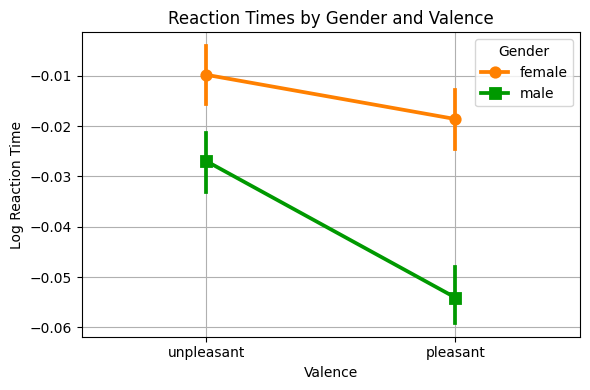

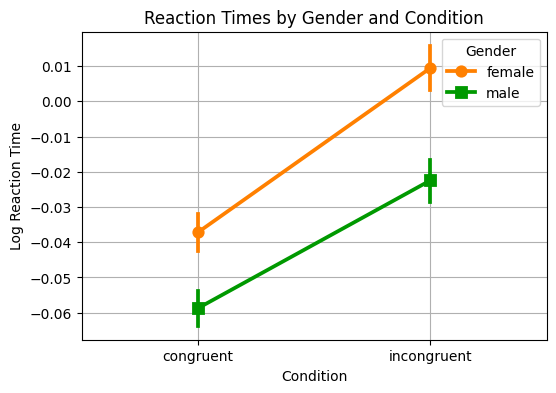

In [37]:
# Define color palette (identical to the one used in Matlab)
maleColor = "#009900"
femaleColor = "#FF8000"

# Interaction plot: Log RTs by gender and valence
plt.figure(figsize=(6,4))
sns.pointplot(
    data=aat_data,
    x='Valence',
    y='LogRT',
    hue='Gender',
    errorbar='ci',
    markers=["o", "s"],
    linestyles=["-", "-"],
    palette={"male": maleColor, "female": femaleColor}
)
plt.title('Reaction Times by Gender and Valence')
plt.gca().set_xticklabels(['unpleasant', 'pleasant'])
plt.xlabel('Valence')
plt.ylabel('Log Reaction Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interaction plot: Log RTs by gender and condition
plt.figure(figsize=(6,4))
sns.pointplot(
    data=aat_data,
    x='Condition',
    y='LogRT',
    hue='Gender',
    errorbar='ci',
    markers=["o", "s"],
    linestyles=["-", "-"],
    palette={"male": maleColor, "female": femaleColor}
)
plt.title('Reaction Times by Gender and Condition')
plt.xlabel('Condition')
plt.ylabel('Log Reaction Time')
plt.grid(True)
plt.show()